# SVM Directional Classifiers
The purpose of this notebook is to create a Support Vector Machine that is capable of classfying the direction (better than random) of each asset class, with the final goal of seeing how well each SVM predicts the direction of bitcoin returns in order to get a better sense of its behavior. The features used in each independent SVM are as follows:
1. Price Volatility
2. Price Momentum
3. Price  Variance (Result of GARCH analysis)

In [1]:
#Importing Neccesary Packages
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score # 
from sklearn import linear_model
from sklearn import svm
from scipy import stats
import seaborn as sns; sns.set()

import numpy as np
import numpy.random as r
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd

 In many ways, there are loads of parameters to be optimized here, however, while I am, at once trying to optimize for the prediction, I am really just trying to extract insights into the Asset Class itself and from that perspective, I will attempt to rationally choose certain smoothing parameters.

In [2]:
data = pd.read_csv("Final_Data.csv")
data.set_index('Date',inplace = True)
print(data.shape)
data.head()

(3627, 12)


,SNP_Close,SNP_Volume,GLD_Close,GLD_Volume,EUR_Close,EUR_Volume,USD_Close,USD_Volume,CBND_Close,CBND_Volume,TBND_Close,TBND_Volume
Date,,,,,,,,,,,,
2004-11-19,-0.011224,-1.740063,0.008973,0.271874,0.004888,1.418665,-0.010727,0.082009,-0.005258,-0.819043,-0.005495,0.489545
2004-11-22,0.005878,-1.848352,0.003789,0.318723,0.001956,1.396135,0.000378,0.080116,-0.000447,-0.793952,0.000703,-0.608626
2004-11-23,-0.000255,-1.819561,-0.004459,-0.895031,0.003007,1.380100,0.001598,0.080919,0.001251,-0.838895,-0.000938,-0.600090
2004-11-24,0.004087,-2.044953,0.006682,-0.491322,0.007309,1.392799,-0.005153,0.084316,-0.000089,-0.843064,0.001406,-0.672622
2004-11-26,0.000753,-2.566598,0.005313,-0.904862,0.008452,1.351151,-0.002114,0.075066,-0.003578,-0.852473,-0.003637,-0.666729


In [3]:
#First we will calculate the Price Volatility and Momentum
#Keeping them in a separate dataframe
#The training is on a binary variable
#We will correspond the last n days, to an m day forecast
#therefore, we will use n = 20 and predict 20 days (month) forward
#The question being asked is: If the stock volatility and momentum are here relative to a month
#Where will they be in one month
n = 20 #Monthly Smoothing 
i = 0
vm_df = pd.DataFrame(data.index[n-1:])
vm_df.set_index('Date',inplace = True)
vol_ar = np.zeros(data.shape[0] - n + 1)
mom_ar = np.zeros(data.shape[0] - n + 1)
for column in data:
    if i % 2 == 0:
        prices = data[column].values
        temp_mom = np.zeros(data.shape[0])
        for d in range(data.shape[0]):
            if prices[d] > 0:
                temp_mom[d] = 1
            elif prices[d] < 0:
                temp_mom[d] = -1
        for j in range(data.shape[0]-n+1):
            vol_ar[j] = np.average(prices[j:j+n])
            mom_ar[j] = np.average(temp_mom[j:j+n])
        vm_df[column + ' Vol'] = vol_ar
        vm_df[column + ' Moment'] = mom_ar
    i+=1


In [110]:
#Remember, the first 19 days are missing (n being 20)
print(data.shape[0] - vm_df.shape[0])
print(vm_df.shape)
print(vm_df.index[0], vm_df.index[-1])
vm_df.head()

19
(3608, 12)
2004-12-17 2019-04-18


,SNP_Close Vol,SNP_Close Moment,GLD_Close Vol,GLD_Close Moment,EUR_Close Vol,EUR_Close Moment,USD_Close Vol,USD_Close Moment,CBND_Close Vol,CBND_Close Moment,TBND_Close Vol,TBND_Close Moment
Date,,,,,,,,,,,,
2004-12-17,0.000448,0.0,-0.000215,0.0,0.001327,0.1,-0.000017,0.1,-2.629105e-04,0.2,-0.000263,-0.1
2004-12-20,0.001028,0.1,-0.000494,0.0,0.001405,0.1,0.000476,0.1,-3.575668e-05,0.2,0.000070,0.0
2004-12-21,0.001184,0.1,-0.000819,-0.1,0.001229,0.0,0.000585,0.1,8.937159e-06,0.3,0.000105,0.0
2004-12-22,0.001367,0.2,-0.000822,-0.1,0.001143,0.0,0.000446,0.0,1.498367e-17,0.3,0.000100,0.0
2004-12-23,0.001186,0.2,-0.000873,-0.1,0.001240,0.0,0.000391,0.0,9.367013e-05,0.4,-0.000035,-0.1


In [13]:
#Creating a dictionary of the training data
asset_dict = {}
i = 0
col_names = ['snp','gld','eur','usd','cbnd','tbnd']
for column in col_names:
    asset_dict[column] = vm_df.iloc[:-20,i:i+2].values
    i+=2

In [14]:
# snp = vm_df.iloc[:-20,0:2].values
# gld = vm_df.iloc[:-20,2:4].values
# eur = vm_df.iloc[:-20,4:6].values
# usd = vm_df.iloc[:-20,6:8].values
# cbnd = vm_df.iloc[:-20,8:10].values
# tbnd = vm_df.iloc[:-20,10:12].values

# Building the Dependent Variable Y
That will simply be 1 or -1 (for increase or decrease).
But this is not so simple as we must do this relative to x days prior(i.e) our test dataset must be shaped a little differently.
It must be made up to see if, relative to the price at day 1, day 20's price has gone up or down.
Simple calculation as you will never access that as a training example except when 20 days out. Requires accessing the original dataset.

In [15]:
data_prices = pd.read_csv('Final_Data_Prices.csv')
data_prices.set_index('Date',inplace = True)
data_prices.head()

,SNP_Close,SNP_Volume,GLD_Close,GLD_Volume,EUR_Close,EUR_Volume,USD_Close,USD_Volume,CBND_Close,CBND_Volume,TBND_Close,TBND_Volume
Date,,,,,,,,,,,,
2004-11-18,1183.550049,1456700000,44.380001,5992000,1.29590,1.095909e+12,104.218,605919.2051,112.500000,274900,85.769997,110100
2004-11-19,1170.339966,1526600000,44.779999,11655300,1.30225,1.116012e+12,103.106,598165.6066,111.910004,105700,85.300003,2162100
2004-11-22,1177.239990,1392700000,44.950001,11996000,1.30480,1.105935e+12,103.145,595693.1925,111.860001,171300,85.360001,168100
2004-11-23,1176.939941,1428300000,44.750000,3169200,1.30873,1.098762e+12,103.310,596742.0947,112.000000,53800,85.279999,183600
2004-11-24,1181.760010,1149600000,45.049999,6105100,1.31833,1.104442e+12,102.779,601179.7988,111.989998,42900,85.400002,51900


In [16]:
#We need to compare the data at day 0 and day 20, if larger than day 0
#set equal to 1, else -1
i = 0
y_df = pd.DataFrame()
for column in data_prices:
    if i % 2 == 0:
        temp_arr = np.zeros(data_prices.shape[0] - n)
        for j in range(data_prices.shape[0] - n):
            if data_prices[column][j] < data_prices[column][j+n]:
                temp_arr[j] = 1
            else:
                temp_arr[j] = -1
        y_df[column + ' dep'] = temp_arr
    i += 1

In [17]:
#This starts 20 days out
y_df.shape

(3608, 6)

In [30]:
dep_dict = {}
i = 0
col_names = ['snp','gld','eur','usd','cbnd','tbnd']
for column in col_names:
    y = y_df.iloc[20:,i:i+1].values
    y = y.reshape(y.shape[0],)
    dep_dict[column] = y
    i+=1

In [21]:
# snp_dep = y_df.iloc[20:,0:1].values
# gld_dep = y_df.iloc[20:,1:2].values
# eur_dep = y_df.iloc[20:,2:3].values
# usd_dep = y_df.iloc[20:,3:4].values
# cbnd_dep = y_df.iloc[20:,4:5].values
# tbnd_dep = y_df.iloc[20:,5:6].values

# Trial 1: Reproducing Princeton Results
In this paper: https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf, titled Predicting Stock Price Direction using Support Vector Machines, Saahil Madge uses an SVM model in order to train a classifier for directional stock price movement n days out, based on m day smoothing. I will attempt to reproduce a slightly simpler version of his results by focusing on the two variables mentioned, momentum and variance, for each asset class rather than using a stock and an index, as done in the original paper.

In [ ]:
#Require Looping and regularization tactics
#Must write out a plan for this section - important component of paper
#then have a part that visualizes the results
#Explain why we will be using the radial basis function
#Trying the RBF and Polynomial Kernels for different values of c and gamma?
#Each itteration should output to a nice clean table
#Code should be able to be reused


Support Vector Machines are based on the premise of a separating hyperplane, which categorizes new examples in binary fashion, by where they fall relative to the models support vectors. In SVM, a kernel helps transform the data using linear algebra, often times transforming the data into a higher-dimensional space in order to aid in separability. Because SVM training can take a long time, and can be prone to overfitting (causes tight margins), regularization parameters can be provided (value C in svm a.k.a. the lamdba in other models however due to the use of Lagrangian Duality, it is likely avoided here). For large values of C, optimization chooses small margin hyperplane (fits tighter), and for small values of C, chooses wider margins (more classification error).

There is another parameter in these models known as Gamma that I will explore. Simply put, the gamma param describes the influence of the distance of training examples from the margin (i.e. low values mean more points are considered). 

At its root, the SVM is built on support vectors which are simply data points that are close to and which influence the shape of the hyperplane. This is where the gamma param comes in. 

In [ ]:
#in this case, we can build a loop to capture the outcome for each regularization param
#X_train, X_test, y_train, y_test = train_test_split(snp,snp_dep,test_size = 0.3)

In [33]:
from sklearn.model_selection import KFold

def svc_train(X, y, kernel = 'rbf', c = 0.1, g = .005, n = 10):
    svc_kernel = svm.SVC(probability = False, kernel = kernel, C = c, gamma = g)
    kf = KFold(n_splits = n, random_state = None, shuffle = True)
    
    max_test = 0
    max_train = 0
    model = None
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        mod = svc_kernel.fit(X_train, y_train)
        
        #Training Accuracy
        yhat_train = svc_kernel.predict(X_train)
        acc_train = np.mean(yhat_train == y_train)
        
        #Testing Accuracy
        yhat_test = svc_kernel.predict(X_test)
        acc_test = np.mean(yhat_test == y_test)
        
        if acc_test > max_test:
            max_test = acc_test
            max_train = acc_train
            model = mod
    #print('Best Test Accuracy = {0:f}'.format(max_test))
    return(c,g,model,max_train,max_test)

In [43]:
#Now comes the training part
svm_outputs = {'snp':[],'gld':[],'eur':[],'usd':[],'cbnd':[],'tbnd':[]}
cVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gammaVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
kern = "rbf"
num_splits = 10
for key in dep_dict.keys():
    X = asset_dict[key]
    y = dep_dict[key]
    for c_ in cVals:
        for g_ in gammaVals:
            svm_outputs[key].append(svc_train(X,y,kernel = kern, c = c_, g = g_, n = num_splits))

In [55]:
#Let's get the best models
top_models = {}
for key in svm_outputs.keys():
    maxi_test = 0
    maxi_train = 0
    for item in svm_outputs[key]:
        if item[-1] >= maxi_test and item[-2] > maxi_train:
            top_models[key] = item
            maxi_test = item[-1]
            maxi_train = item[-2]
        elif item[-1] > maxi_test:
            top_models[key] = item
            maxi_test = item[-1]
            maxi_train = item[-2]

In [67]:
#Let's generate a dataframe of C's and G's
output_data = pd.DataFrame(index = gammaVals, columns = cVals)
output_data
for item in svm_outputs['snp']:
    output_data[item[0]][item[1]] = item[-1]
output_data

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0
0.0001,0.699164,0.701117,0.689944,0.67688,0.67688,0.701117,0.701117
0.0010,0.668524,0.699164,0.665738,0.670391,0.67688,0.679666,0.684358
0.0100,0.693593,0.662953,0.668524,0.674095,0.668524,0.685237,0.679666
0.1000,0.674095,0.688022,0.689944,0.678771,0.679666,0.685237,0.684358
1.0000,0.67688,0.688022,0.693593,0.690808,0.662953,0.682451,0.660167
10.0000,0.696379,0.685237,0.689944,0.687151,0.675978,0.701117,0.696379
100.0000,0.674095,0.665738,0.690808,0.685237,0.690808,0.67688,0.684358


In [161]:
#generate a table from the top_models dictionary
ind = ['C_Param','Gamma','Train_Accuracy','Test_Accuracy']
column = ['snp','gld','eur','usd','cbnd','tbnd']
top_data = pd.DataFrame(index = ind, columns = column)
for key in top_models.keys():
    top_data[key]['C_Param'] = top_models[key][0]
    top_data[key]['Gamma'] = top_models[key][1]
    top_data[key]['Train_Accuracy'] = top_models[key][-2]
    top_data[key]['Test_Accuracy'] = top_models[key][-1]

In [162]:
top_data

,snp,gld,eur,usd,cbnd,tbnd
C_Param,10,0.001,1,0.0001,10,0.001
Gamma,10,0.01,100,100,1,0.01
Train_Accuracy,0.641176,0.530195,0.532053,0.504181,0.530341,0.527408
Test_Accuracy,0.701117,0.604457,0.579387,0.579387,0.614525,0.612813


In [71]:
#Borrowed from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

def plot_svc_decision_function(model, ax = None, plot_support = True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

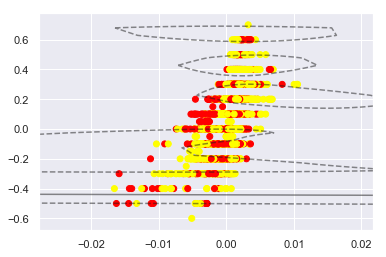

In [76]:
plt.scatter(asset_dict['snp'][:,0],asset_dict['snp'][:,1],c = dep_dict['snp'], cmap = 'autumn')
plot_svc_decision_function(top_models['snp'][-3])

In [90]:
r = np.exp(-(asset_dict['snp'][0:50,:] ** 2).sum(1))

from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-180, 180], azip=[-180, 180],
         X=fixed(asset_dict['snp'][0:50,:]), y=fixed(dep_dict['snp'][0:50]));

#For optimal idea of sepparability check out azim = 74, elev = 180

interactive(children=(Dropdown(description='elev', options=(-180, 180), value=-180), IntSlider(value=30, descr…

# Adding Results from ARIMA  to the dataset
In this section, I will be appending the results from the ARIMA/GARCH Analysis and seeing whether the predicted ARIMA values relative to the actual values can do a better job. We will conclude by comparing results from the model with simple price volatility and price momentum and that with the third feature of arima predicted smoothed returns

In [103]:
arima_res = pd.read_csv("ResidualARIMAData.csv")
arima_res.set_index('Date', inplace = True)
print(arima_res.index[0],arima_res.index[-1])
arima_res.head()

2004-11-19 2019-04-17


,SNP_Close,GLD_Close,EUR_Close,USD_Close,CBND_Close,TBND_Close
Date,,,,,,
2004-11-19,0.017103,-0.005183,-0.002932,0.011105,-0.000956,0.006198
2004-11-22,0.002731,-0.010884,-0.000402,0.006832,0.000705,0.001538
2004-11-23,0.006740,0.003716,0.004056,-0.002013,0.000046,0.003418
2004-11-24,0.000988,0.001590,0.004046,0.001103,-0.003149,-0.002383
2004-11-26,-0.003495,-0.001537,-0.006288,0.005859,-0.008109,-0.004627


In [ ]:
#Conditions on the two new columns are as follows:
#1. the data_range is (2004-23-12 to 2019-04-17) (As a result of smoothing + Garch cuts)
#2. therefore must correct old data by cutting last two rows and update
#new data by removing first 20 rows
#3. then, consider the opportunities for smoothing (last n days var for ex.)
#4. We will do a 20 day smoothing for variance and see how it impact the pred

In [100]:
#Normalize each column
# from sklearn import preprocessing
# for column in arima_res:
#     arima_res[column] = preprocessing.scale(arima_res[column].values)

In [104]:
#Applying Smoothing to Arima_Residual Values
n = 20
i = 0
res_df = pd.DataFrame(arima_res.index[n-1:])
res_df.set_index('Date', inplace = True)
res_ar = np.zeros(arima_res.shape[0] - n + 1)
for column in arima_res:
    residuals = arima_res[column].values
    for j in range(arima_res.shape[0] - n +1):
        res_ar[j] = np.average(residuals[j:j+n])
    res_df[column] = res_ar

In [137]:
print(asset_dict['snp'].shape)
res_df.columns = ['snp','gld','eur','usd','cbnd','tbnd']
res_df.head()

(3588, 3)


,snp,gld,eur,usd,cbnd,tbnd
Date,,,,,,
2004-12-17,0.001633,-0.002300,-0.001450,0.002241,-0.000098,0.001361
2004-12-20,0.001216,-0.002152,-0.001481,0.001820,-0.000017,0.001134
2004-12-21,0.001295,-0.001856,-0.001468,0.001398,0.000018,0.001022
2004-12-22,0.000915,-0.001740,-0.001286,0.001181,0.000119,0.000789
2004-12-23,0.000584,-0.001589,-0.001218,0.000891,0.000008,0.000705


In [135]:
for key in asset_dict.keys():
    asset_dict[key] = np.hstack((asset_dict[key],res_df[key][:-19].values.reshape(res_df.shape[0]-19,1)))

In [301]:
output_data = np.vstack((asset_dict['snp'],asset_dict['eur'],asset_dict['gld'],asset_dict['tbnd']))

In [303]:
#Qucickly create for export(kmeans)
class_num = 4
out_dep = np.zeros(output_data.shape[0])
occur = 0
for j in range(class_num):
    out_dep[asset_dict['snp'].shape[0]*j:asset_dict['snp'].shape[0]*(j+1)] = j
    

In [306]:
out_dep = out_dep.reshape(out_dep.shape[0],1)
csv_data = np.hstack((output_data,out_dep))

In [308]:
output_df = pd.DataFrame(csv_data)
output_df.to_csv('kmeans_df.csv')

In [138]:
svm_updated_outputs = {'snp':[],'gld':[],'eur':[],'usd':[],'cbnd':[],'tbnd':[]}
cVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gammaVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
kern = "rbf"
num_splits = 10
for key in dep_dict.keys():
    X = asset_dict[key]
    y = dep_dict[key]
    for c_ in cVals:
        for g_ in gammaVals:
            svm_updated_outputs[key].append(svc_train(X,y,kernel = kern, c = c_, g = g_, n = num_splits))

In [139]:
top_updated_models = {}
for key in svm_updated_outputs.keys():
    maxi_test = 0
    maxi_train = 0
    for item in svm_updated_outputs[key]:
        if item[-1] >= maxi_test and item[-2] > maxi_train:
            top_updated_models[key] = item
            maxi_test = item[-1]
            maxi_train = item[-2]
        elif item[-1] > maxi_test:
            top_updated_models[key] = item
            maxi_test = item[-1]
            maxi_train = item[-2]

In [159]:
#generate a table from the top_models dictionary
ind = ['C_Param','Gamma','Train_Accuracy','Test_Accuracy']
column = ['snp','gld','eur','usd','cbnd','tbnd']
top_updated_data = pd.DataFrame(index = ind, columns = column)
for key in top_updated_models.keys():
    top_updated_data[key]['C_Param'] = top_updated_models[key][0]
    top_updated_data[key]['Gamma'] = top_updated_models[key][1]
    top_updated_data[key]['Train_Accuracy'] = top_updated_models[key][-2]
    top_updated_data[key]['Test_Accuracy'] = top_updated_models[key][-1]

In [323]:
columns = ['S&P 500', 'Gold', "EUR/USD", "USD/JPN", "Corp_Bonds", "Treas_Bonds"]
top_updated_data.columns = columns
top_updated_data

,S&P 500,Gold,EUR/USD,USD/JPN,Corp_Bonds,Treas_Bonds
C_Param,100,0.0001,100,1,10,0.001
Gamma,0.0001,0.001,100,0.001,0.1,1
Train_Accuracy,0.638278,0.529412,0.560855,0.504644,0.531124,0.527554
Test_Accuracy,0.713092,0.611732,0.598886,0.575419,0.612813,0.611732


In [158]:
#It seems to have added relatively important information (in finance a 1% increase can be worth loads of money)

In [322]:
columns = ['S&P 500', 'Gold', "EUR/USD", "USD/JPN", "Corp_Bonds", "Treas_Bonds"]
top_data.columns = columns
top_data

,S&P 500,Gold,EUR/USD,USD/JPN,Corp_Bonds,Treas_Bonds
C_Param,10,0.001,1,0.0001,10,0.001
Gamma,10,0.01,100,100,1,0.01
Train_Accuracy,0.641176,0.530195,0.532053,0.504181,0.530341,0.527408
Test_Accuracy,0.701117,0.604457,0.579387,0.579387,0.614525,0.612813


# Applying Bitcoin Returns to SVM Classifiers

In this section, I will import bitcoin returns and run the SVM Classifiers top_models generated from before to see how well these models can predict bitcoin returns to shed light on relationships between BTC and some of these datapoints.

In [246]:
btc = pd.read_csv("BTC_Final.csv")

In [247]:
btc.head()
btc.set_index('Date',inplace = True)
column = ['BTC_Volume']
btc.drop(column, inplace = True, axis = 1)
print(btc.shape)
btc.head()

(3200, 1)


,BTC_Close
Date,
2010-07-17,0.550310
2010-07-18,-0.060508
2010-07-19,-0.077962
2010-07-20,0.058087
2010-07-21,-0.450129


In [248]:
n = 30 #Monthly Smoothing 
btc_vm = pd.DataFrame(btc.index[n-1:])

btc_vm.set_index('Date',inplace = True)

vol_ar = np.zeros(btc.shape[0] - n + 1)
mom_ar = np.zeros(btc.shape[0] - n + 1)

prices = btc['BTC_Close'].values

temp_mom = np.zeros(btc.shape[0])

for d in range(btc.shape[0]):
    if prices[d] > 0:
        temp_mom[d] = 1
    elif prices[d] < 0:
        temp_mom[d] = -1
for j in range(btc.shape[0]-n+1):
    vol_ar[j] = np.average(prices[j:j+n])
    mom_ar[j] = np.average(temp_mom[j:j+n])
btc_vm['BTC Vol'] = vol_ar
btc_vm['BTC Moment'] = mom_ar

In [249]:
btc_vm.shape

(3171, 2)

In [250]:
#Need to import original price data to extract dependent array
btc_price = pd.read_csv('BTC_Prices.csv')
btc_price.set_index('Date', inplace = True)
column = ['BTC_Volume']
btc_price.drop(column, inplace = True, axis = 1)
btc_price.drop(btc_price.index[0], axis = 0, inplace = True)
btc_price.shape

(3200, 1)

In [251]:
btc_dep = pd.DataFrame()
temp_arr = np.zeros(btc_price.shape[0] - n)
btc_temp = btc_price['BTC_Close'].values
for j in range(btc_price.shape[0] - n):
    if btc_temp[j] < btc_temp[j+n]:
        temp_arr[j] = 1
    else:
        temp_arr[j] = -1
btc_dep['BTC_dep'] = temp_arr

In [252]:
btc_dep.set_index(btc_price.index[0:-n], inplace = True)
btc_dep.drop(btc_dep.index[0:n], axis = 0, inplace = True)

In [253]:
#Check to see if actually a month off (Correct)
btc_dep.head()

,BTC_dep
Date,
2010-08-16,-1.0
2010-08-17,-1.0
2010-08-18,-1.0
2010-08-19,-1.0
2010-08-20,-1.0


In [254]:
#Importing Arima Predictions for BTC
btc_arima = pd.read_csv("BTC_Arima_Residuals.csv")
btc_arima.set_index('Date', inplace = True)

In [262]:
btc_vm_update = btc_vm.iloc[1400:,:]
btc_update_dep = btc_dep.iloc[1369:]
btc_vm_update.shape

(1771, 2)

In [256]:
n = 30
i = 0
btc_arima_df = pd.DataFrame(btc_arima.index[n-1:])
btc_arima_df.set_index('Date', inplace = True)
res_ar = np.zeros(btc_arima.shape[0] - n + 1)

residuals = btc_arima['BTC_Res'].values
for j in range(btc_arima.shape[0] - n +1):
    res_ar[j] = np.average(residuals[j:j+n])
btc_arima_df['BTC_Res'] = res_ar

In [257]:
#Checking math
np.average(btc_arima.iloc[1:31,0])

0.010108795175013502

In [258]:
btc_arima_df.shape

(1771, 1)

In [259]:
#Hstacking to get test data

BTC_final = np.hstack((btc_vm_update['BTC Vol'].values.reshape(btc_vm_update.shape[0],1),btc_vm_update['BTC Moment'].values.reshape(btc_vm_update.shape[0],1),btc_arima_df['BTC_Res'].values.reshape(btc_vm_update.shape[0],1)))

In [280]:
#Now testing BTC on the top_model svc
btc_update_dep = btc_update_dep['BTC_dep'].values

{'snp': (100, 0.0001, SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.6382781046763704, 0.713091922005571),
 'gld': (0.0001,
  0.001,
  SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  0.5294117647058824,
  0.611731843575419),
 'eur': (100, 100, SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.5608547537937442, 0.5988857938718662),
 'usd': (1, 0.001, SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', de

In [335]:
X_train, X_test, y_train, y_test = train_test_split(BTC_final,btc_update_dep,test_size = 0.1)

In [336]:
model_updated_output = {}
for key in top_updated_models.keys():
        svc_kernel = top_updated_models[key][-3]
        
        #Training Accuracy
        yhat_train = svc_kernel.predict(X_train)

        acc_train = np.mean(yhat_train == y_train)
        
        #Testing Accuracy
        yhat_test = svc_kernel.predict(X_test)
        acc_test = np.mean(yhat_test == y_test)
        
        model_updated_output[key + ' BTC'] = (acc_train, acc_test)

In [337]:
model_updated_output

{'snp BTC': (0.5637162586315129, 0.6067415730337079),
 'gld BTC': (0.5637162586315129, 0.6067415730337079),
 'eur BTC': (0.6949152542372882, 0.6741573033707865),
 'usd BTC': (0.5637162586315129, 0.6067415730337079),
 'cbnd BTC': (0.5021971123666039, 0.5674157303370787),
 'tbnd BTC': (0.5637162586315129, 0.6067415730337079)}

In [288]:
X_train, X_test, y_train, y_test = train_test_split(BTC_final[:,0:2],btc_update_dep,test_size = 0.1)

In [290]:
model_output = {}
for key in top_models.keys():
        svc_kernel = top_models[key][-3]
        
        #Training Accuracy
        yhat_train = svc_kernel.predict(X_train)

        acc_train = np.mean(yhat_train == y_train)
        
        #Testing Accuracy
        yhat_test = svc_kernel.predict(X_test)
        acc_test = np.mean(yhat_test == y_test)
        
        model_output[key + ' BTC'] = (acc_train, acc_test)

In [291]:
model_output

{'snp BTC': (0.5674827369742624, 0.5955056179775281),
 'gld BTC': (0.5655994978028877, 0.5898876404494382),
 'eur BTC': (0.37602008788449465, 0.33146067415730335),
 'usd BTC': (0.5655994978028877, 0.5898876404494382),
 'cbnd BTC': (0.4745762711864407, 0.47191011235955055),
 'tbnd BTC': (0.5655994978028877, 0.5898876404494382)}

In [ ]:
ind = ['C_Param','Gamma','Train_Accuracy','Test_Accuracy']
column = ['snp','gld','eur','usd','cbnd','tbnd']
top_updated_data = pd.DataFrame(index = ind, columns = column)
for key in top_updated_models.keys():
    top_updated_data[key]['C_Param'] = top_updated_models[key][0]
    top_updated_data[key]['Gamma'] = top_updated_models[key][1]
    top_updated_data[key]['Train_Accuracy'] = top_updated_models[key][-2]
    top_updated_data[key]['Test_Accuracy'] = top_updated_models[key][-1]

In [346]:
#Generating 2 Feature TABLE
ind = ['C_Param','Gamma','Bitcoin Train_Accuracy','Bitcoin Test_Accuracy']
column = ['snp','gld','eur','usd','cbnd','tbnd']
btc_table = pd.DataFrame(index = ind, columns = column)
for key in top_updated_models.keys():
    btc_table[key]['C_Param'] = top_models[key][0]
    btc_table[key]['Gamma'] = top_models[key][1]
    btc_table[key]['Bitcoin Train_Accuracy'] = model_output[key + ' BTC'][0]
    btc_table[key]['Bitcoin Test_Accuracy'] = model_output[key + ' BTC'][1]

In [347]:
#Generating 3 Feature TABLE
ind = ['C_Param','Gamma','Bitcoin Train_Accuracy','Bitcoin Test_Accuracy']
column = ['snp','gld','eur','usd','cbnd','tbnd']
btc_table_update = pd.DataFrame(index = ind, columns = column)
for key in top_updated_models.keys():
    btc_table_update[key]['C_Param'] = top_updated_models[key][0]
    btc_table_update[key]['Gamma'] = top_updated_models[key][1]
    btc_table_update[key]['Bitcoin Train_Accuracy'] = model_updated_output[key + ' BTC'][0]
    btc_table_update[key]['Bitcoin Test_Accuracy'] = model_updated_output[key + ' BTC'][1]

In [348]:
columns = ['S&P 500', 'Gold', "EUR/USD", "USD/JPN", "Corp_Bonds", "Treas_Bonds"]
btc_table.columns = columns
btc_table

,S&P 500,Gold,EUR/USD,USD/JPN,Corp_Bonds,Treas_Bonds
C_Param,10,0.001,1,0.0001,10,0.001
Gamma,10,0.01,100,100,1,0.01
Bitcoin Train_Accuracy,0.567483,0.565599,0.37602,0.565599,0.474576,0.565599
Bitcoin Test_Accuracy,0.595506,0.589888,0.331461,0.589888,0.47191,0.589888


In [349]:
columns = ['S&P 500', 'Gold', "EUR/USD", "USD/JPN", "Corp_Bonds", "Treas_Bonds"]
btc_table_update.columns = columns
btc_table_update

,S&P 500,Gold,EUR/USD,USD/JPN,Corp_Bonds,Treas_Bonds
C_Param,100,0.0001,100,1,10,0.001
Gamma,0.0001,0.001,100,0.001,0.1,1
Bitcoin Train_Accuracy,0.563716,0.563716,0.694915,0.563716,0.502197,0.563716
Bitcoin Test_Accuracy,0.606742,0.606742,0.674157,0.606742,0.567416,0.606742


Please disregard the following: Code for utilizing GARCH which proved ineffective

In [ ]:
# n = 20 #Monthly Smoothing 
# i = 0
# variance_moment_vol_df = pd.DataFrame(garch_var.index[n-1:])
# variance_moment_vol_df.set_index('Date',inplace = True)
# var_vol_ar = np.zeros(garch_var.shape[0] - n + 1)
# var_mom_ar = np.zeros(garch_var.shape[0] - n + 1)
# for column in garch_var:
#     prices = garch_var[column].values
#     temp_mom = np.zeros(garch_var.shape[0])
#     for d in range(garch_var.shape[0]):
#         if prices[d] > 0:
#             temp_mom[d] = 1
#         elif prices[d] < 0:
#             temp_mom[d] = -1
#     for j in range(garch_var.shape[0]-n+1):
#         var_vol_ar[j] = np.average(prices[j:j+n])
#         var_mom_ar[j] = np.average(temp_mom[j:j+n])
#     variance_moment_vol_df[column + ' Var Vol'] = var_vol_ar
#     variance_moment_vol_df[column + ' Var Moment'] = var_mom_ar

In [143]:
# print(variance_moment_vol_df.shape)
# print(variance_moment_vol_df.index[0],variance_moment_vol_df.index[-1])
# variance_moment_vol_df


In [144]:
# snp = vm_df.iloc[:-20,0:2].values
# gld = vm_df.iloc[:-20,2:4].values
# eur = vm_df.iloc[:-20,4:6].values
# usd = vm_df.iloc[:-20,6:8].values
# cbnd = vm_df.iloc[:-20,8:10].values
# tbnd = vm_df.iloc[:-20,10:12].values

In [145]:
# snp_var = variance_moment_vol_df.iloc[:-19,0:2]
# gld_var = variance_moment_vol_df.iloc[:-19,2:4]
# eur_var = variance_moment_vol_df.iloc[:-19,4:6]
# usd_var = variance_moment_vol_df.iloc[:-19,6:8]
# cbnd_var = variance_moment_vol_df.iloc[:-19,8:10]
# tbnd_var = variance_moment_vol_df.iloc[:-19,10:12]

In [146]:
# snp_fin = np.hstack((snp[4:],snp_var))
# gld_fin = np.hstack((snp[4:],gld_var))
# eur_fin = np.hstack((snp[4:],eur_var))
# usd_fin = np.hstack((snp[4:],usd_var))
# cbnd_fin = np.hstack((snp[4:],cbnd_var))
# tbnd_fin = np.hstack((snp[4:],tbnd_var))

In [147]:
# print(snp_dep.shape)
# snp_fin.shape

In [148]:
# snp_dep = y_df.iloc[24:,0:1].values
# gld_dep = y_df.iloc[24:,1:2].values
# eur_dep = y_df.iloc[24:,2:3].values
# usd_dep = y_df.iloc[24:,3:4].values
# cbnd_dep = y_df.iloc[24:,4:5].values
# tbnd_dep = y_df.iloc[24:,5:6].values

In [149]:
# snp_dep.shape

In [150]:
# X_train, X_test, y_train, y_test = train_test_split(usd_fin,usd_dep,test_size = 0.3)

In [151]:
#Training a model
# svc = svm.SVC(probability = False, kernel = "rbf", C = 2.8, gamma = .0073, verbose = 10)

In [152]:
# y_train = y_train.reshape(y_train.shape[0],)
# y_test = y_test.reshape(y_test.shape[0],)
# print(y_train)

In [153]:
# svc.fit(X_train,y_train)

In [154]:
# yhat_ts = svc.predict(X_test)
# acc = np.mean(yhat_ts == y_test)
# print('Accuaracy = {0:f}'.format(acc))

In [155]:
# plt.scatter(X_test[:,0], X_test[:,1], c = y_test[:], s = 50, cmap = 'autumn')